In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
from torch.utils.tensorboard import SummaryWriter

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# Assuming you have a dataset in the 'data' directory with train and val subdirectories.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

train_dataset = datasets.ImageFolder('flower/Train', transform=data_transforms['train'])
val_dataset = datasets.ImageFolder('flower/Test', transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [3]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

print("Number of train samples: ", len(train_dataset))
print("Number of test samples: ", len(val_dataset))

Number of train samples:  4131
Number of test samples:  186


In [4]:
class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNet, self).__init__()
        self.effnet = EfficientNet.from_pretrained('efficientnet-b0')
        num_ftrs = self.effnet._fc.in_features
        self.effnet._fc = nn.Linear(num_ftrs, num_classes)
         # Change this to use a specific block (e.g., block 2)
        self.layer = nn.Sequential(*list(self.effnet.children())[:2])

    def forward(self, x):
        return self.effnet(x)
        

#Number of classes in your dataset
num_classes = len(train_dataset.classes)

# Create an instance of the custom model
model = CustomEfficientNet(num_classes)

Loaded pretrained weights for efficientnet-b0


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of training epochs
num_epochs = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CustomEfficientNet(
  (effnet): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSameP

In [20]:
writer = SummaryWriter()

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Training Loss: {running_loss/len(train_loader):.4f}, '
          f'Validation Loss: {val_loss/len(val_loader):.4f}, '
          f'Validation Accuracy: {(correct/total)*100:.2f}%')
    
    # Log training loss
    writer.add_scalar('Training Loss', running_loss / len(train_loader), epoch)

    # Log validation loss and accuracy
    writer.add_scalar('Validation Loss', val_loss / len(val_loader), epoch)
    writer.add_scalar('Validation Accuracy', (correct / total) * 100, epoch)

# Close the SummaryWriter
writer.close()
print('Training finished!')

Epoch 1/2, Training Loss: 0.2895, Validation Loss: 0.3128, Validation Accuracy: 90.32%
Epoch 2/2, Training Loss: 0.3306, Validation Loss: 0.2862, Validation Accuracy: 90.32%
Training finished!


In [134]:
import torch
from torch import nn
from timm import create_model

/home/ali/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [136]:
# Assume you have a model instance named 'model' (tuned EfficientNet model)
# Replace 'efficientnet_b3' with the appropriate EfficientNet variant you are using
model = create_model('efficientnet_b3', pretrained=False)  

# Define the path where you want to save the model
save_path = 'test.pth'  # Replace with your desired path and filename

# Save the model's state dictionary
torch.save(model.state_dict(), save_path)

print(f'Model saved to {save_path}')

Model saved to test.pth


In [21]:
# Save the entire model
model_path = 'Tuned_Models/model.pth'
torch.save(model, model_path)

In [16]:
#saving the model state dictornary 
model_path = 'Tuned_Models/efficientnet_finetuned.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Model saved to Tuned_Models/efficientnet_finetuned.pth


In [137]:
#revalidating model on new test data
test_dataset = datasets.ImageFolder('flower/Test', transform=data_transforms['val'])
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [138]:
from torchsummary import summary


def evaluate_model(model, dataloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += criterion(outputs, labels).item()

    accuracy = (correct / total) * 100
    average_test_loss = test_loss / len(dataloader)

    return accuracy, average_test_loss

In [142]:
# Load the saved model checkpoint
#saved_model_path = 'Efnet/efficientnet_finetuned.pth'
saved_model_path = 'Tuned_Models/efficientnet_finetuned.pth'
#saved_model_path = 'test.pth'
model = CustomEfficientNet(num_classes)  # Assuming you defined CustomEfficientNet as before
model.load_state_dict(torch.load(saved_model_path))
model.to(device)
model.eval()

Loaded pretrained weights for efficientnet-b0


CustomEfficientNet(
  (effnet): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSameP

In [143]:
# Generate a summary of the model
summary(model, (3, 224, 224))  # Assuming input size is (3, 224, 224)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
         ZeroPad2d-2          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-3         [-1, 32, 112, 112]             864
Conv2dStaticSamePadding-4         [-1, 32, 112, 112]             864
       BatchNorm2d-5         [-1, 32, 112, 112]              64
       BatchNorm2d-6         [-1, 32, 112, 112]              64
MemoryEfficientSwish-7         [-1, 32, 112, 112]               0
         ZeroPad2d-8         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-9         [-1, 32, 112, 112]             288
      BatchNorm2d-10         [-1, 32, 112, 112]              64
MemoryEfficientSwish-11         [-1, 32, 112, 112]               0
         Identity-12             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-13              [-1, 8, 1, 1]             264
MemoryEfficie

In [144]:
test_accuracy, test_loss = evaluate_model(model, test_loader, criterion)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.4908
Test Accuracy: 86.56%


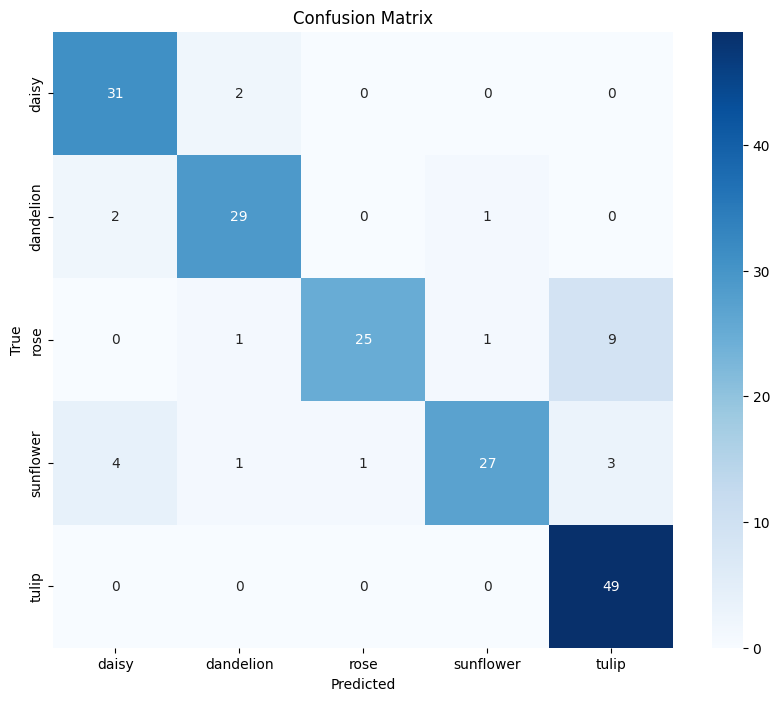

In [27]:
# ... Previous code to preprocess the test data and load the model ...

# Evaluate the model on the test data
def evaluate_model(model, dataloader):
    model.eval()
    all_predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return all_predictions, true_labels

# Evaluate the model
predictions, true_labels = evaluate_model(model, test_loader)


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Define class labels (assuming you have access to the class names)
class_labels = train_dataset.classes

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [34]:
#For infereccing on single image 

from PIL import Image
import matplotlib.pyplot as plt

# Load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = data_transforms['val'](image)
    image = image.unsqueeze(0)  # Add a batch dimension
    return image


# Display the test image
def display_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

image_path = 'flower/Test/rose/19988406792_68201f76e3_n.jpg'  # Replace with the actual image path
preprocessed_image = preprocess_image(image_path)

Test Image:


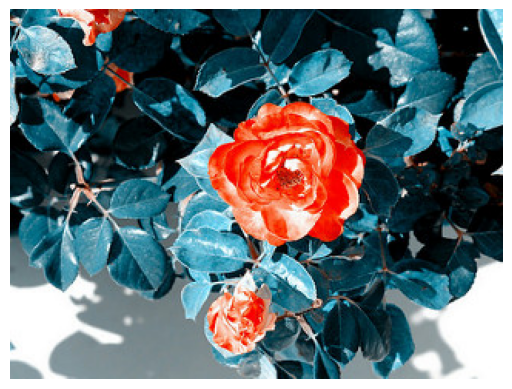

Predicted class: rose
Predicted probability: 0.9999


In [36]:
# Load the saved model checkpoint
saved_model_path = 'Tuned_Models/efficientnet_finetuned.pth'
#model = CustomEfficientNet(num_classes)  # Assuming you defined CustomEfficientNet as before
model.load_state_dict(torch.load(saved_model_path))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Predict the image
with torch.no_grad():
    preprocessed_image = preprocessed_image.to(device)
    output = model(preprocessed_image)
    probabilities = torch.softmax(output, dim=1)

# Get the predicted class label and probability
predicted_class = torch.argmax(output, dim=1).item()
predicted_probability = probabilities[0][predicted_class].item()

# Display the test image
print('Test Image:')
display_image(image_path)

# Get the class label
class_labels = train_dataset.classes  # Assuming train_dataset is available
predicted_label = class_labels[predicted_class]

print(f'Predicted class: {predicted_label}')
print(f'Predicted probability: {predicted_probability:.4f}')

In [90]:
import sys
sys.path.append('/')

import cv2
import numpy as np
from torchvision import models
from efficientnet_pytorch import EfficientNet
from grad_cam import GradCam,GuidedBackpropReLUModel,show_cams,show_gbs,preprocess_image

In [91]:
model = EfficientNet.from_pretrained('efficientnet-b0')
#saved_model_path = 'Tuned_Models/efficientnet_finetuned.pth'
#model = CustomEfficientNet(num_classes)  # Assuming you defined CustomEfficientNet as before
#model.load_state_dict(torch.load(saved_model_path))
model.eval() 
grad_cam = GradCam(model=model, blob_name = '_blocks', target_layer_names=['1','10','15'], use_cuda=False)
img = cv2.imread('flower/Test/rose/19919867648_043cf02fc3.jpg', 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
inputs = preprocess_image(img)
# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested index.
target_index = None
mask_dic = grad_cam(inputs, target_index)
show_cams(img, mask_dic)
gb_model = GuidedBackpropReLUModel(model=model, activation_layer_name = 'MemoryEfficientSwish', use_cuda=False)
show_gbs(inputs, gb_model, target_index, mask_dic)

Loaded pretrained weights for efficientnet-b0


In [128]:
import torch
from torchvision import transforms
from PIL import Image

In [129]:
class GradCam:
    def __init__(self, model, target_layer_names, use_cuda=True):
        self.model = model
        self.target_layer_names = target_layer_names
        self.use_cuda = use_cuda
        self.model.eval()
        self.activations = []
        self.gradients = []

        # Register hooks on target layers
        self.register_hooks()

In [130]:
def register_hooks(self):
        def hook_fn(module, input, output):
            self.activations.append(output)
        
        hooks = []
        for layer in self.target_layer_names:
            module = dict(self.model.named_modules())[layer]
            hook = module.register_forward_hook(hook_fn)
            hooks.append(hook)

        self.hooks = hooks

def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

def forward(self, image):
        return self.model(image)
def backward(self, gradients):
        self.gradients = gradients


In [131]:
def generate_heatmap(self):
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]

        weighted_activations = torch.zeros(activations.size(1)).to(self.device)

        for i, (activation, pooled_gradient) in enumerate(zip(activations, pooled_gradients)):
            weighted_activation = pooled_gradient * activation
            weighted_activations += weighted_activation

        heatmap = weighted_activations.mean(dim=0)
        heatmap = np.maximum(heatmap.cpu(), 0)

        return heatmap


In [132]:
# Assuming you have a function to preprocess the image and get activations from the model
def preprocess_image(image_path):
    # Load and preprocess the image (similar to previous example)
    pass

def get_activations(model, image, target_layer_names):
    # Forward pass to get activations from the specified layers
    pass

def grad_cam(model, image_path, target_layer_names):
    image = preprocess_image(image_path)

    # Initialize GradCam
    grad_cam = GradCam(model, target_layer_names)

    # Generate heatmap
    output = grad_cam.forward(image)
    target = torch.argmax(output)
    grad_cam.backward(output[:, target].reshape(1))
    heatmap = grad_cam.generate_heatmap()

    grad_cam.remove_hooks()  # Remove hooks after generating heatmap

    return heatmap

In [119]:
# Assuming you have a function to load your tuned EfficientNet model
def load_tuned_efficientnet_model(model_path):
    # Load your tuned EfficientNet model
    # Replace this with the appropriate way you load your model
    model = CustomEfficientNet(num_classes)  # Load your model using torch.load or any suitable method
    model.eval()  # Set the model to evaluation mode
    return model

# Assuming you have a function to load and preprocess an image
def load_and_preprocess_image(image_path):
    # Load and preprocess your input image
    # Replace this with the appropriate way to load and preprocess your image
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = preprocess(image)
    return image.unsqueeze(0)  # Add a batch dimension


def grad_cam(model, image, target_layer_name):
    # Initialize GradCam
    grad_cam = GradCam(model, target_layer_name)
    # Generate heatmap
    heatmap = grad_cam.generate_heatmap(image)
    return heatmap


# Function to generate Grad-CAM heatmaps
#def generate_grad_cam(model, image):
    # Assuming you have a function to generate Grad-CAM heatmaps
    # Replace this with the appropriate way you generate Grad-CAM heatmaps
#    grad_cam_heatmap = grad_cam(model, image)
#    return grad_cam_heatmap

# Function to integrate Grad-CAM for inference
#def infer_with_grad_cam(image_path, model_path):
    # Load the tuned EfficientNet model
#    model = load_tuned_efficientnet_model(model_path)
    
    
    # Function to integrate Grad-CAM for inference
def infer_with_grad_cam(image_path, model_path, target_layer_name):
    # Load the tuned EfficientNet model
    model = load_tuned_efficientnet_model(model_path)

    # Load and preprocess the input image
    image = load_and_preprocess_image(image_path)

    # Generate Grad-CAM heatmaps
    grad_cam_heatmap = grad_cam(model, image, target_layer_name)

    # Display the original image
    plt.figure()
    plt.imshow(image.squeeze().permute(1, 2, 0))
    plt.title('Original Image')
    plt.axis('off')

    # Display the Grad-CAM heatmap
    plt.figure()
    plt.imshow(grad_cam_heatmap, cmap='jet')
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    plt.show()

In [133]:
# Example usage
image_path = 'flower/Test/rose/20596941736_f2c5f496cf.jpg'
model_path = 'Tuned_Models/efficientnet_finetuned.pth'
target_layer_name = ['1','10','15']
infer_with_grad_cam(image_path, model_path, target_layer_name)
#infer_with_grad_cam(image_path, model_path)
#print (infer_with_grad_cam)


Loaded pretrained weights for efficientnet-b0


AttributeError: 'GradCam' object has no attribute 'register_hooks'